# Comparison checks for quality control flags
Covers QC8-15

## Table of contents
[QC8 R99p](#QC8---R99p)  
[QC9 PRCPTOT](#QC9---PRCPTOT)  
[QC10 World Record](#QC10---World-Record)  
[QC11 Rx1day](#QC11---Rx1day)  
[QC12 CDD](#QC12---CDD)  
[QC13 Daily accumulations](#QC13---Daily-accumulations)  
[QC14 Monthly accumulations](#QC14---Monthly-accumulations)  
[QC15 Streaks](#QC15---Streaks)  

## Notes:
- The ETCCDI data comes from two models(?): GHCNDEX & HADEX2  
- Many of the checks use the same flags so lots of room for writing consise functions


See '3.3.1 Suspiciously high values' in Lewis et al. (2021)

In [3]:
import datetime

import polars as pl
import xarray as xr
import numpy as np

In [4]:
def read_metadata(data_path):
    metadata = {}

    with open(data_path, 'r') as f:
        while True:
            key, val = f.readline().strip().split(':', maxsplit=1)
            key = key.lower().replace(' ', '_')
            metadata[key.strip()] = val.strip()
            if key == 'other':
                break
    return metadata

In [5]:
metadata = read_metadata(data_path='../data/gauge_data/DE_02483.txt')
startdate = datetime.datetime.strptime(metadata['start_datetime'], '%Y%m%d%H')
enddate = datetime.datetime.strptime(metadata['end_datetime'], '%Y%m%d%H')

In [6]:
rain_col = f'rain_{metadata['original_units']}'

In [7]:
def get_delta(d1, d2):
    delta = d2 - d1
    return delta


hourly_date_interval = []
delta = get_delta(startdate, enddate+datetime.timedelta(days=1))
for i in range(delta.days * 24):
    hourly_date_interval.append(startdate + datetime.timedelta(hours=i))

In [93]:
gauge_data = pl.read_csv('../data/gauge_data/DE_02483.txt', skip_rows=20)

assert len(gauge_data) == len(hourly_date_interval)

## set time columns
gauge_data = gauge_data.with_columns(time=pl.Series(hourly_date_interval))

## Rename
gauge_data = gauge_data.rename({'Other: ': rain_col})

## Reorder (to look nice)
gauge_data = gauge_data.select(['time', rain_col])

In [ ]:
## make no data vals nans
gauge_data = gauge_data.with_columns(pl.when(pl.col(rain_col) == int(metadata['no_data_value'])).then(np.nan).otherwise(pl.col(rain_col)).alias(rain_col))

# QC8 - R99p 
[Back to Index](#Table-of-contents)
"Annual exceedance of the maximum ETCCDI R99p value with seperate flags showing % exceedance"


#### Differences from `intense-qc`:
- The OG method returns lots of flags, do we want that?

#### Problems:
- If using `method='nearest'` to select location, then need have checks that this isn't too far. Maybe use global variable
- Using R99p timeseries seems arbitrary. Do more advanced checks want to include season into the R99p checks?

In [10]:
etccdi_r99p = xr.open_dataset('../data/ETCCDI/RawData_HADEX2_R99p_1951-2010_ANN_from-90to90_from-180to180.nc')
etccdi_r99p

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 60, lat: 73, lon: 96)
Coordinates:
  * time     (time) datetime64[ns] 480B 1951-01-01 1952-01-01 ... 2010-01-01
  * lat      (lat) float32 292B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 384B -180.0 -176.2 -172.5 ... 168.8 172.5 176.2
Data variables:
    R99p     (time, lat, lon) float32 2MB ...
Attributes:
    title:          HADEX2 R99p ANN 1951-2010
    reference:      Donat, M. G., et al. (2013), Updated analyses of temperat...
    copyright:      www.climdex.org
    creation_date:  Thu Oct 31 03:23:42 AEDT 2019

In [11]:
one_gauge_r99p = etccdi_r99p.sel(lon=metadata['longitude'], lat=metadata['latitude'], method='nearest')

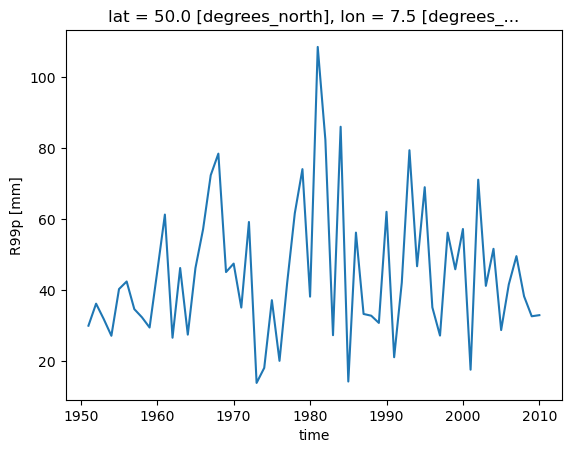

In [12]:
one_gauge_r99p['R99p'].plot()

In [13]:
max_r99p = np.max(one_gauge_r99p['R99p'])
print(max_r99p.data)

108.51884460449219


In [14]:
gauge_data_daily_upsample = gauge_data.upsample('time', every='1d')

## add year col
gauge_data_daily_upsample = gauge_data_daily_upsample.with_columns(pl.col("time").dt.year().alias("year"))

In [20]:
# Calc percentiles
gauge_percentiles = gauge_data_daily_upsample.group_by("year").agg(
    pl.col(rain_col).fill_nan(0.0).quantile(0.99).alias("percentile_99")
)
gauge_percentiles

year,percentile_99
i32,f64
2007,3.4
2010,2.3
2008,2.55
2006,5.0
2009,5.5


In [24]:
# Join percentiles back to the main DataFrame
gauge_data_yearly_percentiles = gauge_data_daily_upsample.join(gauge_percentiles, on="year").fill_nan(0.0)

In [25]:
# Filter values above the 99th percentile
gauge_data_above_annual_r99p = gauge_data_yearly_percentiles.filter(pl.col(rain_col) > pl.col("percentile_99"))

In [26]:
gauge_data_above_annual_r99p

time,rain_mm,year,percentile_99
datetime[μs],f64,i32,f64
2006-03-31 00:00:00,20.4,2006,5.0
2006-08-21 00:00:00,8.4,2006,5.0
2006-10-24 00:00:00,18.2,2006,5.0
2006-11-12 00:00:00,8.1,2006,5.0
2007-04-23 00:00:00,999.0,2007,3.4
…,…,…,…
2009-11-07 00:00:00,9.8,2009,5.5
2010-07-06 00:00:00,3.1,2010,2.3
2010-10-01 00:00:00,30.0,2010,2.3


In [27]:
gauge_data_above_annual_r99_year_sum = gauge_data_above_annual_r99p.group_by_dynamic('time', every='1y').agg(pl.col(rain_col).sum())
gauge_data_above_annual_r99_year_sum

time,rain_mm
datetime[μs],f64
2006-01-01 00:00:00,55.1
2007-01-01 00:00:00,1026.9
2008-01-01 00:00:00,62.0
2009-01-01 00:00:00,59.6
2010-01-01 00:00:00,75.8


In [28]:
## These flags can be cleaned up and made more flexible after having a chat with someone about what would be useful to return 

def day_check(val, max_ref_val):
    """
    From intenseqc -- TO REFACTOR as messy. Do we need this many flags?
    """
    if val >= max_ref_val * 1.5:
        return 4
    elif val >= max_ref_val * 1.33:
        return 3
    elif val >= max_ref_val * 1.2:
        return 2
    elif val >= max_ref_val:
        return 1
    else:
        return 0

In [29]:
[day_check(val=yr, max_ref_val=max_r99p) for yr in gauge_data_above_annual_r99_year_sum[rain_col]]


[0, 4, 0, 0, 0]

In [30]:
## alternative without complex flags
gauge_data_above_annual_r99_year_sum[rain_col] > max_r99p

rain_mm
bool
false
true
false
false
false


# QC9 - PRCPTOT 
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- 

In [31]:
etccdi_prcptot = xr.open_dataset('../data/ETCCDI/RawData_HADEX2_PRCPTOT_1951-2010_ANN_from-90to90_from-180to180.nc')
etccdi_prcptot

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 60, lat: 73, lon: 96)
Coordinates:
  * time     (time) datetime64[ns] 480B 1951-01-01 1952-01-01 ... 2010-01-01
  * lat      (lat) float32 292B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 384B -180.0 -176.2 -172.5 ... 168.8 172.5 176.2
Data variables:
    PRCPTOT  (time, lat, lon) float32 2MB ...
Attributes:
    title:          HADEX2 PRCPTOT ANN 1951-2010
    reference:      Donat, M. G., et al. (2013), Updated analyses of temperat...
    copyright:      www.climdex.org
    creation_date:  Thu Oct 31 03:24:22 AEDT 2019

In [32]:
one_gauge_prcptot = etccdi_prcptot.sel(lon=metadata['longitude'], lat=metadata['latitude'], method='nearest')

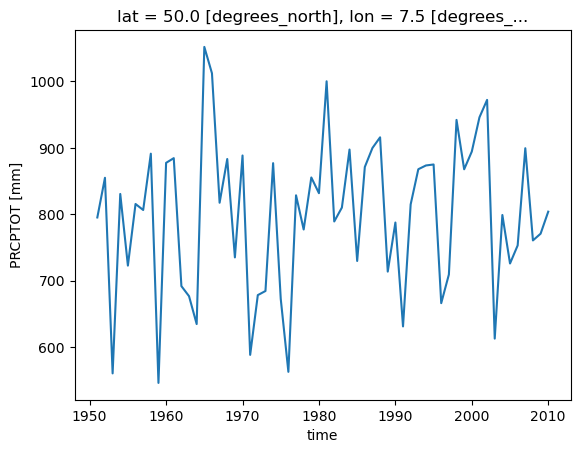

In [33]:
one_gauge_prcptot['PRCPTOT'].plot()

In [34]:
max_prcptot = np.max(one_gauge_prcptot['PRCPTOT'])
print(max_prcptot.data)

1052.08984375


In [35]:
gauge_data_annual_sums = gauge_data.group_by_dynamic('time', every='1y').agg(pl.col(rain_col).drop_nans().sum())
gauge_data_annual_sums

time,rain_mm
datetime[μs],f64
2006-01-01 00:00:00,13055.4
2007-01-01 00:00:00,7668.1
2008-01-01 00:00:00,1571.35
2009-01-01 00:00:00,2042.9
2010-01-01 00:00:00,1274.25


In [36]:
[day_check(val=yr, max_ref_val=max_prcptot) for yr in gauge_data_annual_sums[rain_col]]

[4, 4, 3, 4, 2]

In [37]:
## alternative without complex flags
gauge_data_annual_sums[rain_col] > max_prcptot

rain_mm
bool
true
true
true
true
true


# QC10 - World Record 
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- 

In [104]:
# *** updated to use 401.0 mm in 1 hour - compare e.g.
# http://www.nws.noaa.gov/oh/hdsc/record_precip/record_precip_world.html
# http://www.bom.gov.au/water/designRainfalls/rainfallEvents/worldRecRainfall.shtml
# https://wmo.asu.edu/content/world-meteorological-organization-global-weather-climate-extremes-archive

world_records = {'hourly': 401.0, 'daily': 1825.0}  # mm

In [64]:
# Apply a switch-like function
wr_check = gauge_data.with_columns(
    pl.when(pl.col(rain_col) >= world_records['hourly'] * 1.5).then(4)
    .when(pl.col(rain_col) >= world_records['hourly'] * 1.33).then(3)
    .when(pl.col(rain_col) >= world_records['hourly'] * 1.2).then(2)
    .when(pl.col(rain_col) >= world_records['hourly']).then(1)
    .otherwise(0)
    .alias("world_record_check")
)

In [76]:
wr_check["world_record_check"].value_counts()

world_record_check,count
i32,u32
1,23
0,42750
4,1051


# QC11 - Rx1day 
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- 


#### Problems:
- Compares the hourly values agaisnt daily max (is that okay?)

In [98]:
etccdi_rx1day = xr.open_dataset('../data/ETCCDI/RawData_HADEX2_Rx1day_1951-2010_ANN_from-90to90_from-180to180.nc')
etccdi_rx1day

<xarray.Dataset> Size: 2MB
Dimensions:  (time: 60, lat: 73, lon: 96)
Coordinates:
  * time     (time) datetime64[ns] 480B 1951-01-01 1952-01-01 ... 2010-01-01
  * lat      (lat) float32 292B -90.0 -87.5 -85.0 -82.5 ... 82.5 85.0 87.5 90.0
  * lon      (lon) float32 384B -180.0 -176.2 -172.5 ... 168.8 172.5 176.2
Data variables:
    Rx1day   (time, lat, lon) float32 2MB ...
Attributes:
    title:          HADEX2 Rx1day ANN 1951-2010
    reference:      Donat, M. G., et al. (2013), Updated analyses of temperat...
    copyright:      www.climdex.org
    creation_date:  Wed Jul 11 09:47:33 AEST 2018

In [101]:
one_gauge_rx1day = etccdi_rx1day.sel(lon=metadata['longitude'], lat=metadata['latitude'], method='nearest')

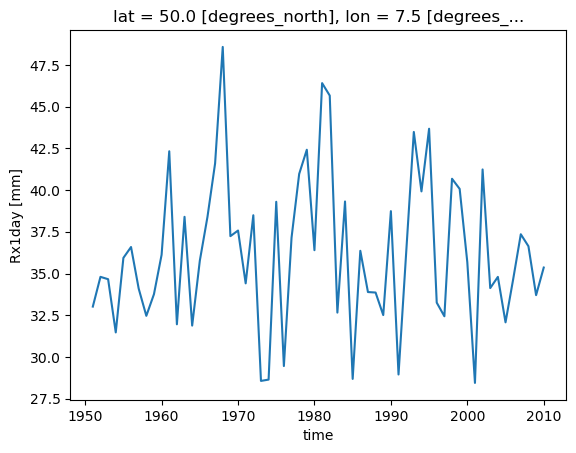

In [102]:
one_gauge_rx1day['Rx1day'].plot()

In [105]:
max_rx1day = np.max(one_gauge_rx1day['Rx1day'])
print(max_rx1day.data)

48.572288513183594


In [106]:
# Apply a switch-like function
rx1day_check = gauge_data.with_columns(
    pl.when(pl.col(rain_col) >= max_rx1day * 1.5).then(4)
    .when(pl.col(rain_col) >= max_rx1day * 1.33).then(3)
    .when(pl.col(rain_col) >= max_rx1day * 1.2).then(2)
    .when(pl.col(rain_col) >= max_rx1day).then(1)
    .otherwise(0)
    .alias("rx1day_check")
)

In [107]:
rx1day_check["rx1day_check"].value_counts()

rx1day_check,count
i32,u32
4,1078
0,42740
1,6


# QC12 - CDD 
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- 

# QC13 - Daily accumulations
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- 

# QC14 - Monthly accumulations 
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- 

# QC15 - Streaks 
[Back to Index](#Table-of-contents)

#### Differences from `intense-qc`: 
- 